In [1]:
import os
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint


if not os.path.exists("data/MNIST"):
    MNIST("data", train=True, download=True)
    MNIST("data", train=False, download=True)

batch_size = 256
num_workers = 8
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])
    
mnist_full = MNIST("data", train=True, transform=transform)
train_data, valid_data = random_split(mnist_full, [55000, 5000])
test_data = MNIST("data", train=False, transform=transform)

train_dataloader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)
test_dataloader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [2]:
# https://gist.github.com/dbsrlskfdk/6ed795232e7231143e1aa7d6863ba4a4?fbclid=IwAR2uvS2m13dIT3fmGyGkOscccr8DJhsojF-r50Nq51M59r4dHtSMGgNsRBc
class Generator(nn.Module):
    def __init__(self, z_size=100):
        super().__init__()
        self.layer1 = nn.Sequential(OrderedDict([
                        #('fc1', nn.Linear(z_size, middle_size)),
                        ('convt1', nn.ConvTranspose2d(z_size, 1024, 2, 1, 0)),
                        ('bn1', nn.BatchNorm2d(1024)),
                        ('relu1', nn.ReLU()),
                        ('convt2', nn.ConvTranspose2d(1024, 512, 4, 2, 1)),
                        ('bn2', nn.BatchNorm2d(512)),
                        ('relu2',nn.ReLU()),
        ]))
        
        self.layer2 = nn.Sequential(OrderedDict([
                        ('convt3', nn.ConvTranspose2d(512, 256, 3, 2, 1)),
                        ('bn3', nn.BatchNorm2d(256)),
                        ('relu3', nn.ReLU()),
                        ('convt4', nn.ConvTranspose2d(256, 128, 4, 2, 1)),
                        ('bn4', nn.BatchNorm2d(128)),
                        ('relu4', nn.ReLU()),
                        ('convt5', nn.ConvTranspose2d(128, 1, 4, 2, 1)),
                        ('tanh', nn.Tanh()),
        ]))
    
    
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = out.view(-1, 1, 28, 28)
        
        return out
    
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(OrderedDict([
                        ('conv1', nn.Conv2d(1, 128, 4, 2, 1, bias=False)),
                        ('act1', nn.LeakyReLU(0.2, inplace=True)),
                        ('conv2', nn.Conv2d(128, 256, 4, 2, 1, bias=False)),
                        ('bn1', nn.BatchNorm2d(256)),
                        ('act2', nn.LeakyReLU(0.2, inplace=True)),
                        ('conv3', nn.Conv2d(256, 512, 3, 2, 1, bias=False)),
                        ('bn2', nn.BatchNorm2d(512)),
                        ('act3', nn.LeakyReLU(0.2, inplace=True)),

        ]))

        self.layer2 = nn.Sequential(OrderedDict([
                        ('conv4', nn.Conv2d(512, 1024, 4, 2, 1, bias=False)),
                        ('bn3', nn.BatchNorm2d(1024)),
                        ('act4', nn.LeakyReLU(0.2, inplace=True)),
                        ('conv5', nn.Conv2d(1024, 1, 2, 1, 0, bias=False)),
                        ('sigmoid', nn.Sigmoid()),
        ]))
    
    
    def forward(self, x):
        out = x.view(-1, 1, 28, 28)
        out = self.layer1(out)
        out = self.layer2(out)
        
        return out.squeeze(-1).squeeze(-1)
    

z_size = 100    
generator = Generator(z_size=z_size)
discriminator = Discriminator()

In [3]:
class GAN(pl.LightningModule):
    def __init__(self, generator, discriminator):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
    
    
    def forward(self, z):
        return self.generator(z) 
    
    
    def sample_z(self, batch_size):
        return torch.randn(batch_size, 100, 1, 1)
    
    
    def generator_step(self, imgs):
        valid = torch.ones(imgs.size(0), 1)
        valid = valid.type_as(imgs)
        
        z = self.sample_z(imgs.shape[0])
        z = z.type_as(imgs)
        
        g_loss = F.binary_cross_entropy(self.discriminator(self(z)), valid)
        
        return g_loss
    
    
    def discriminator_step(self, imgs):
        valid = torch.ones(imgs.size(0), 1)
        valid = valid.type_as(imgs)

        real_loss = F.binary_cross_entropy(self.discriminator(imgs), valid)
    
        z = self.sample_z(imgs.shape[0])
        z = z.type_as(imgs)
        
        fake = torch.zeros(imgs.size(0), 1)
        fake = fake.type_as(imgs)
        
        fake_loss = F.binary_cross_entropy(self.discriminator(self(z).detach()), fake)

        d_loss = (real_loss + fake_loss) / 2
        
        return d_loss
        
        
    def training_step(self, batch, batch_idx, optimizer_idx):
        imgs, _ = batch
        
        # generator
        if optimizer_idx == 0:
            g_loss = self.generator_step(imgs)
            self.log('train_g_loss', g_loss, on_step=False, on_epoch=True, prog_bar=True)
            
            return g_loss
        # discriminator
        elif optimizer_idx == 1:
            d_loss = self.discriminator_step(imgs)
            self.log('train_d_loss', d_loss, on_step=False, on_epoch=True, prog_bar=True)
            
            return d_loss
    
    
    def validation_step(self, batch, batch_idx):
        imgs, _ = batch
        g_loss = self.generator_step(imgs)
        d_loss = self.discriminator_step(imgs)
        
        self.log('valid_g_loss', g_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('valid_d_loss', d_loss, on_step=False, on_epoch=True, prog_bar=True)
        
        
    def configure_optimizers(self):
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        return [opt_g, opt_d], []

    
callbacks = [
    ModelCheckpoint(monitor='valid_g_loss', save_top_k=5, dirpath='weights/DCGAN', filename='DCGAN-{epoch:03d}-{valid_g_loss:.4f}-{valid_d_loss:.4f}'),
]
    
model = GAN(generator, discriminator)
trainer = pl.Trainer(gpus=1, max_epochs=30, enable_progress_bar=True, callbacks=callbacks)

/home/ubuntu/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:429: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [4]:
trainer.fit(model, train_dataloader, valid_dataloader)

/home/ubuntu/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/ubuntu/Workspace/PapersWithCode_GenerativeModels/weights/DCGAN exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 10.5 M
1 | discriminator | Discriminator | 10.1 M
------------------------------------------------
20.6 M    Trainable params
0         Non-trainable params
20.6 M    Total params
82.449    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

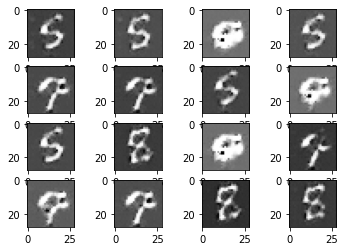

In [5]:
ckpt_fname = "DCGAN-epoch=010-valid_g_loss=0.5034-valid_d_loss=6.6778.ckpt"
model = model.load_from_checkpoint("weights/DCGAN/" + ckpt_fname, generator=generator, discriminator=discriminator)

samples = model(torch.randn(16, 100, 1, 1)).view(-1, 1, 28, 28)
samples = samples.detach().moveaxis(1, -1).to("cpu").numpy()

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(samples[i, :], cmap="gray")

plt.show()